# FargoCPT Selfgravity

This notebook guides you enabling self-gravity and plotting the accelerations.

First we create a new directory and change to it.

In [1]:
example_name = "401_Selfgravity"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $example_name
    os.chdir(example_name)
print("We are currently in", os.getcwd())

We are currently in /home/rometsch/repo/fargocpt/examples/401_Selfgravity


## Make sure the code is built by running make again.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C ../../src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

119 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp ../config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [5]:
config["nbody"][1]["accretion efficiency"] = "2"
config["DT"] = 0.314 # monitor scalar files around every half orbit
config["Ninterm"] = 20 # write a snapshot every orbit
config["Ntot"] = 10 # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps
try:
    del config["Nrad"]
except KeyError:
    pass
try:
    del config["Nsec"]
except KeyError:
    pass

config["cps"] = 2

config["WriteSGAccelRad"] = "yes"
config["WriteSGAccelAzi"] = "yes"
config["WriteToomre"] = "yes"

config["SelfGravity"] = "yes"



with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

## Run the simulation

In [6]:
import sys
sys.path.append("../../bin")
from fargocpt import run_fargo
configfile = "setup.yml"
run_fargo(2, 1, ["start", configfile], detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmp4i6fm1qu -x OMP_NUM_THREADS=1 /home/rometsch/repo/fargocpt/bin/fargocpt start setup.yml
fargo process pid 824260



In [7]:
print(os.listdir(config["OutputDir"]))
snapshots = os.listdir(config["OutputDir"]+ "/snapshots")
snapshots.sort()
print(snapshots)

['vtheta1D.info', 'parameters', 'vrad1D.info', 'a_sg_azi1D.info', 'a_sg_rad1D.info', 'snapshots', 'fargocpt_output_v1_3', 'used_rad.dat', 'energy1D.info', 'constants.yml', 'info2D.yml', 'monitor', 'dimensions.dat', 'Toomre1D.info', 'logs', 'units.yml', 'Sigma1D.info']
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'damping', 'list.txt', 'timeSnapshot.dat']


Following is an overview widget for the simulation. You can use the slider to scrub through the different snapshots.

In [8]:
import sys
sys.path.append("../../Tools")
from overview import Overview

Run the next cell again to refresh the snapshot list.

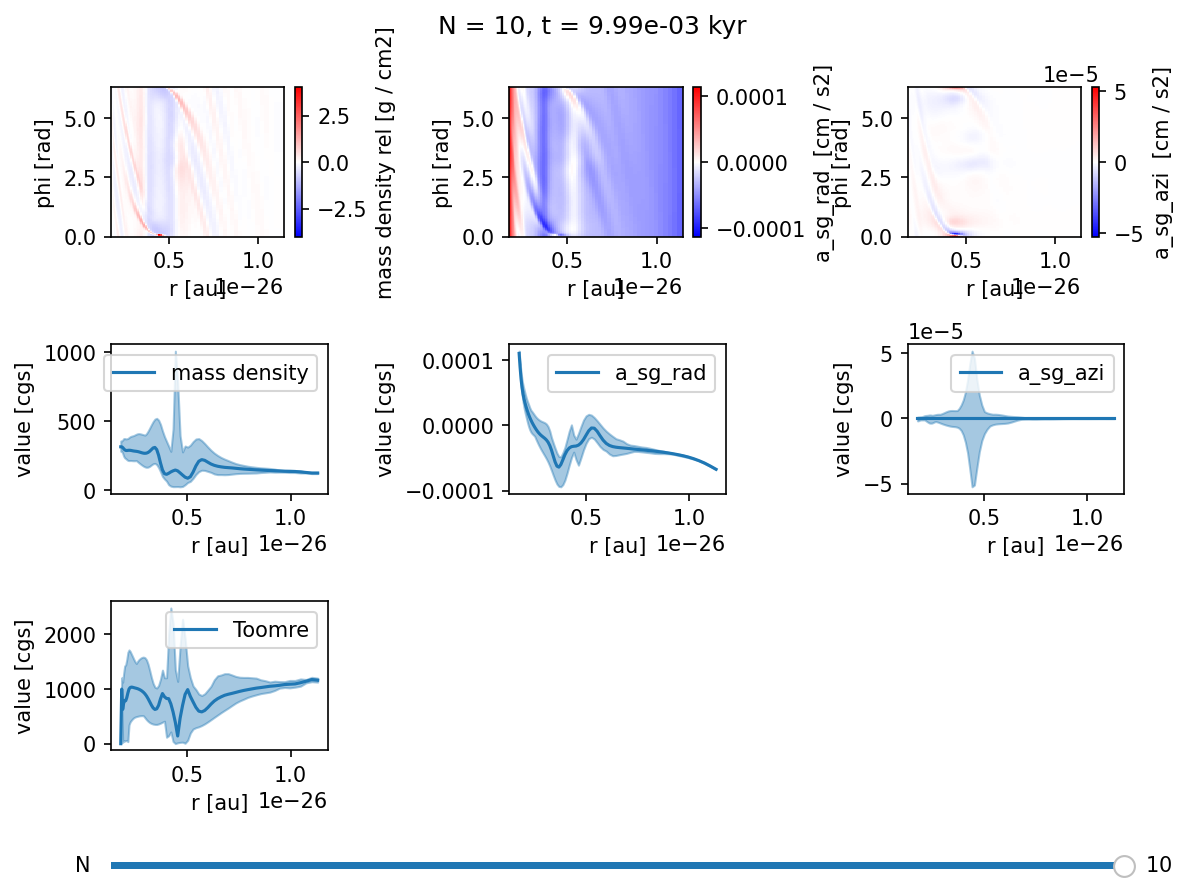

In [9]:
overview = Overview("output/out/", 
                    vars=["2:mass density:rel,rphi",
                          "2:a_sg_rad:rphi",
                          "2:a_sg_azi:rphi",
                          "1:mass density:minmax",
                          "1:a_sg_rad:minmax",
                          "1:a_sg_azi:minmax",
                          "1:Toomre:minmax"])
overview.create();

## Visualizing SG accelerations

We turned on output of the self-gravity accelerations.
Let's have a look.

In [10]:
import numpy as np
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt

def plot_field(data, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis", title=None):
    field = data.get(var=name, dim="2d", N=N)
    if dataunit is None:
        dataunit = field.data.unit
    Z = field.data.to_value(dataunit)

    ri = field.grid.get_interfaces("r").to_value("au")
    phii = field.grid.get_interfaces("phi").to_value("rad")
    PHI, R = np.meshgrid(phii, ri)
    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(X,Y,Z, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = field.time.to_value("kyr")
    if title is None:
        title = ""
    else:
        title += "\n"
    title += f" t={t:.2e}kyr, N={N}"
    ax.set_title(title)

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

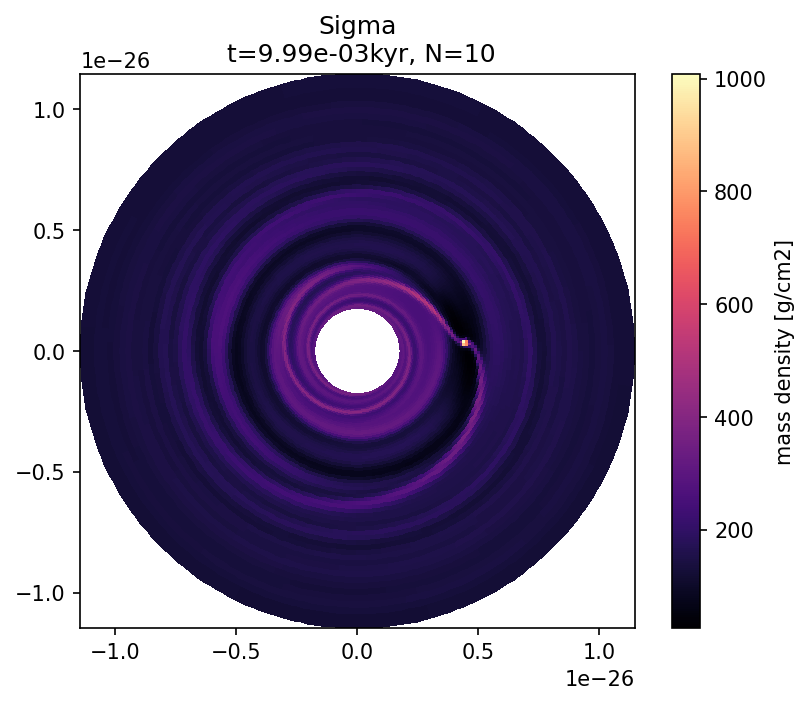

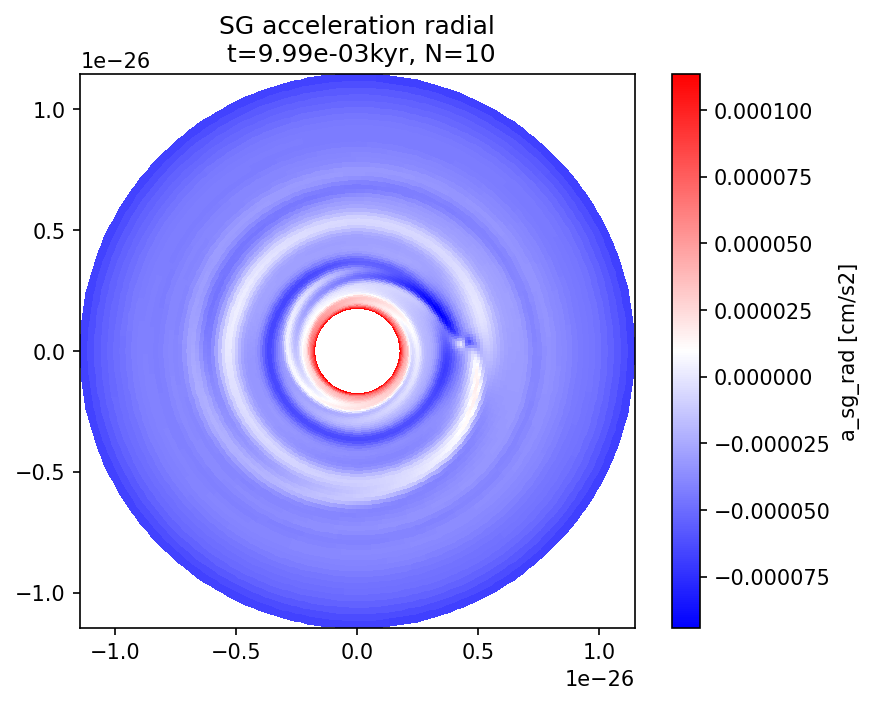

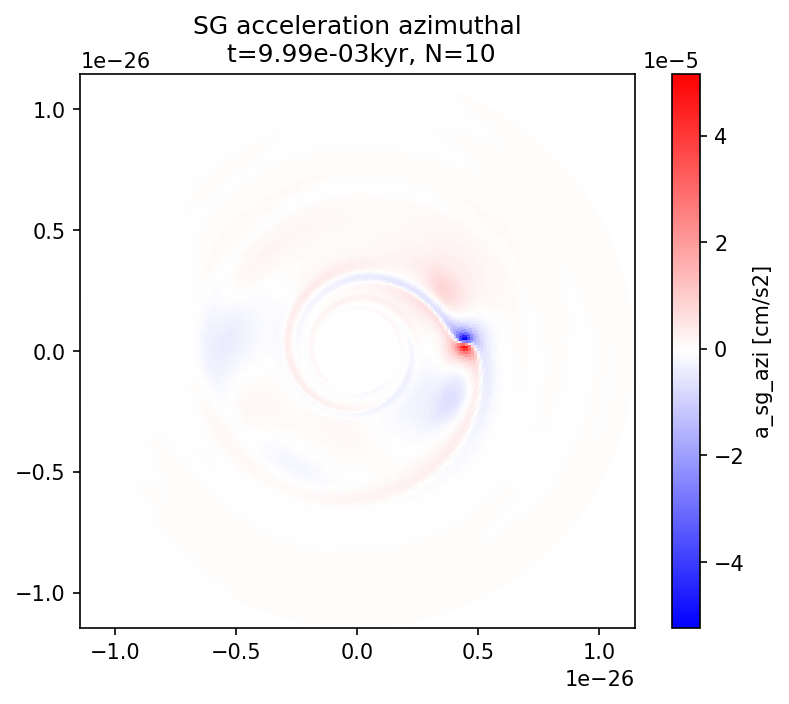

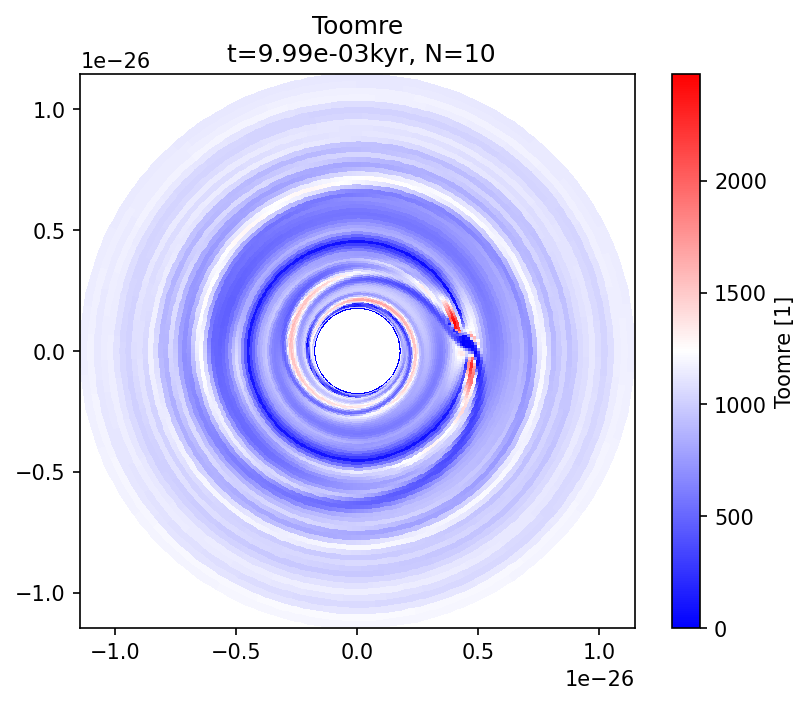

In [11]:
import disgrid
d = disgrid.Data("output/out/")
Nlast = d.avail()["Nlast"]
plot_field(d, "mass density", Nlast, dataunit="g/cm2", cmap="magma", title="Sigma");
plot_field(d, "a_sg_rad", Nlast, dataunit="cm/s2", cmap="bwr", title="SG acceleration radial");
plot_field(d, "a_sg_azi", Nlast, dataunit="cm/s2", cmap="bwr", title="SG acceleration azimuthal");
plot_field(d, "Toomre", Nlast, dataunit="1", cmap="bwr", title="Toomre");